In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
# chrmosome 16, Gm12878, do process in quinn paper 
# 1) process chr 16 Gm12878 chipseq data according to quinn paper- should roughly match DONE
# 2) Generate binding profile
# 3) find chr 16 intrachromosome Hi-C data DONE
# 4) train neural net!


# 1) Get mark profile

In [3]:
# h3k9me3_data = pd.read_csv('wgEncodeBroadHistoneGm12878H3k9me3StdAln.narrowPeak', sep="\t", header=None)
# h3k9me3_data.columns = ["chromosome", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"]

# h3k9me3_data = pd.read_csv('ENCFF519VDJ.bed', sep="\t", header=None)
# h3k9me3_data.columns = ["chromosome", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"]

# bigwig file from quinn bottom up paper, then converted to bedgraph using bigWigToBedGraph from UCSC command line tool on WSL
h3k9me3_data = pd.read_csv('output.bedGraph', sep="\t", header=None)
h3k9me3_data.columns = ["chromosome", "start", "end", "value"]

In [107]:
# isolate chromosome 16
chr16_h3k9me3_data = h3k9me3_data[h3k9me3_data["chromosome"] == "chr16"] #.groupby("chromosome")
chr16_h3k9me3_data.sort_values("start", inplace=True)
# chr16_h3k9me3_data#head()

C:\Users\tmhab\AppData\Local\Temp\ipykernel_21496\1480449248.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr16_h3k9me3_data.sort_values("start", inplace=True)


In [72]:
%%time
# convert matrix of ranges into 1d array

# 1. Determine the size of the array
array_size = chr16_h3k9me3_data['end'].max()

# 2. Initialize the 1D array with zeros
h3k9me3_signal_bp = np.zeros(array_size)

# 3. Use numpy's vectorized approach to fill the array
# For each row, we create a range from start to end and assign the value

# Create a mask for each range and use broadcasting
starts = chr16_h3k9me3_data['start'].values
ends = chr16_h3k9me3_data['end'].values
values = chr16_h3k9me3_data['value'].values

# Create an array of indices from all ranges using np.concatenate and np.arange
indices = np.concatenate([np.arange(s, e) for s, e in zip(starts, ends)])

# Repeat the values according to the length of each interval
repeated_values = np.repeat(values, ends - starts)

# Assign the values to the appropriate positions in result_array
np.add.at(h3k9me3_signal_bp, indices, repeated_values)

# Display the result
print(h3k9me3_signal_bp)

[0.   0.   0.   ... 0.56 0.56 0.56]
CPU times: total: 4.23 s
Wall time: 7.5 s


In [76]:
# integrate (sum) over nucleosomes
nuc_per_bp = 200
trimmed_size = (h3k9me3_signal_bp.size // nuc_per_bp) * nuc_per_bp
# print(trimmed_size)
reshaped_arr = h3k9me3_signal_bp[:trimmed_size].reshape(-1, nuc_per_bp)

# 2. Sum along the rows (axis 1)
h3k9me3_signal_nuc = np.sum(reshaped_arr, axis=1)

451470

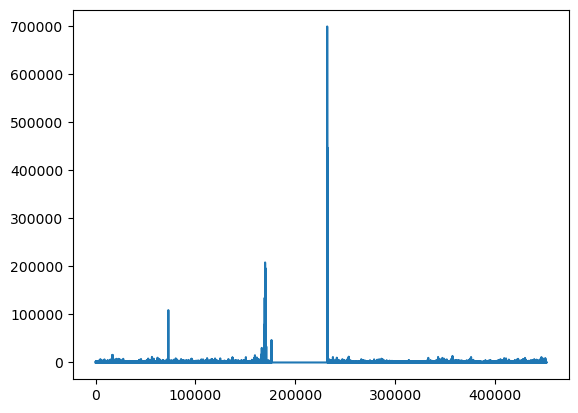

In [82]:
plt.plot(np.arange(len(h3k9me3_signal_nuc)), h3k9me3_signal_nuc)

In [88]:
num_nucs = len(h3k9me3_signal_nuc)

one_mark_cutoff = 220
two_mark_cutoff = one_mark_cutoff*2
print("# NO mark nucs: ", np.sum(h3k9me3_signal_nuc<one_mark_cutoff))
print("# one mark nucs: ", np.sum(1*(h3k9me3_signal_nuc>=one_mark_cutoff) * 1*(h3k9me3_signal_nuc<two_mark_cutoff)))
print("# two mark nucs: ", np.sum(h3k9me3_signal_nuc>=two_mark_cutoff))

# np.sum(h3k9me3_signal_nuc>=two_mark_cutoff)

# NO mark nucs:  189916
# one mark nucs:  99726
# two mark nucs:  161828


In [95]:
1*(h3k9me3_signal_nuc>=one_mark_cutoff) * 1*(h3k9me3_signal_nuc<two_mark_cutoff)

array([0, 0, 0, ..., 0, 0, 0])

In [97]:
marks_1 = np.zeros(num_nucs)

marks_1[np.where(h3k9me3_signal_nuc<one_mark_cutoff)] = 0
marks_1[np.where(1*(h3k9me3_signal_nuc>=one_mark_cutoff) * 1*(h3k9me3_signal_nuc<two_mark_cutoff))] = 1
marks_1[np.where(h3k9me3_signal_nuc>=two_mark_cutoff)] = 2

In [109]:
print("# zero mark nucs: ", np.sum(marks_1==0))
print("# one mark nucs: ",  np.sum(marks_1==1))
print("# two mark nucs: ", np.sum(marks_1==2))


# zero mark nucs:  189916
# one mark nucs:  99726
# two mark nucs:  161828


Text(0, 0.5, '$\\sigma_i^{(1)}$')

<Figure size 640x480 with 0 Axes>

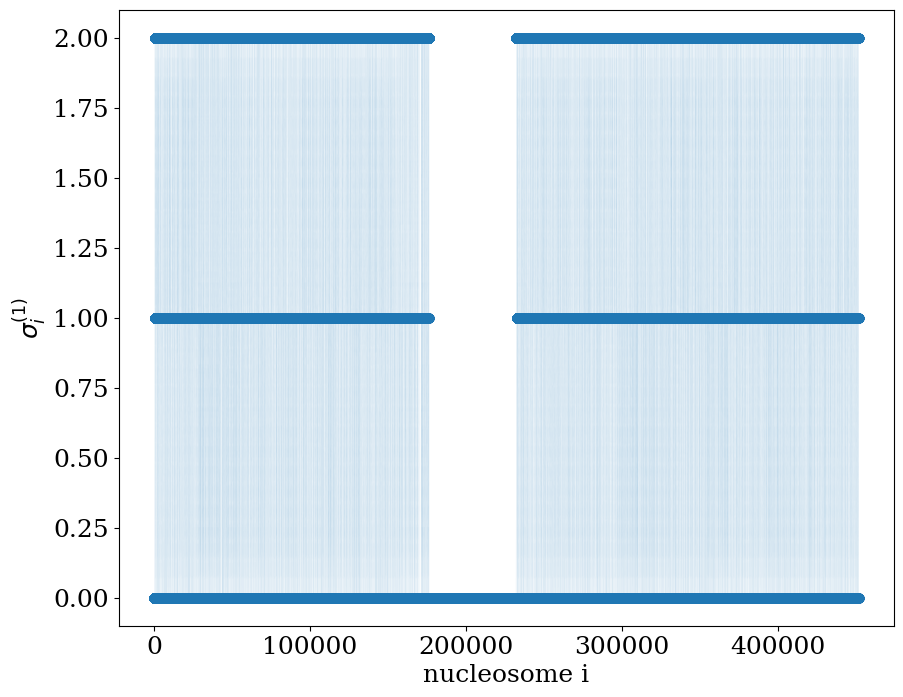

In [356]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(np.arange(len(marks_1)), marks_1, linewidth = 0.01)
plt.scatter(np.arange(len(marks_1)), marks_1)
plt.xlabel("nucleosome i")
plt.ylabel(r"$\sigma_i^{(1)}$")

# 2) Binding profile TODO

# 3) Get the Hi-C

In [ ]:
# Get normalized observed, then normalized expected then do O/E analysis

In [224]:
Hi_c_raw_obs = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_1mb.RAWobserved", sep="\t", header=None)
Hi_c_raw_obs.columns = ["i","j",r"$M_{ij}$"]
Hi_c_KRnorm = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_1mb.KRnorm")

# Hi_c_raw_exp = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_1mb.RAWexpected", sep="\t", header=None)
# Hi_c_raw_exp.columns = ["i","j",r"$M_{ij}$"]
Hi_c_KRexpected = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_1mb.KRexpected")
resolution = 1e6 #1mb

In [228]:
Hi_c_raw_obs#[r"$M_{ij}$"].values

,i,j,$M_{ij}$
0,0,0,427176.0
1,0,1000000,107415.0
2,1000000,1000000,431344.0
3,0,2000000,29197.0
4,1000000,2000000,82222.0
...,...,...,...
3316,86000000,90000000,1675.0
3317,87000000,90000000,3349.0
3318,88000000,90000000,6295.0
3319,89000000,90000000,34619.0


In [262]:
# (Hi_c_KRnorm[(Hi_c_raw_obs["i"].values // 1e6).astype(int)])
# Hi_c_KRnorm[(Hi_c_raw_obs["j"].values // 1e6).astype(int)]

## KR normalization of observed Hi-C data

In [265]:
# Hi_c_KRnorm#.values

In [276]:
# Hi_c_Kr_obs = M_ij / (Hi_c_KRnorm[ i value int divide by 1e7]*Hi_c_KRnorm[ j value int divide by 1e7])

Hi_c_Kr_obs = Hi_c_raw_obs[r"$M_{ij}$"].values / (Hi_c_KRnorm[(Hi_c_raw_obs["i"].values // resolution).astype(int)]*Hi_c_KRnorm[(Hi_c_raw_obs["j"].values // resolution).astype(int)])

In [278]:
Hi_c_Kr_obs

array([442732.35437198, 104734.43314127, 395674.85574671, ...,
        19347.5726569 ,  88154.06351783, 508568.61140395])

In [280]:
Hi_c_raw_obs[r"$M_{ij}^{KR}$"] = Hi_c_Kr_obs

## Obs/Exp

In [283]:
# observed/expected correction
i_j_diff = Hi_c_raw_obs["i"].values - Hi_c_raw_obs["j"].values
Kr_indices = (i_j_diff // resolution).astype(int)
Hi_c_Kr_OE = Hi_c_Kr_obs / Hi_c_KRexpected[Kr_indices]

In [285]:
Hi_c_Kr_OE

array([  1.52154513, 116.37401554,   1.35982189, ...,  27.05379845,
        97.95099902,   1.74780561])

In [287]:
Hi_c_raw_obs[r"$(O/E)^{KR}$"] = Hi_c_Kr_OE

In [289]:
Hi_c_raw_obs

,i,j,$M_{ij}$,$M_{ij}^{KR}$,$(O/E)^{KR}$
0,0,0,427176.0,442732.354372,1.521545
1,0,1000000,107415.0,104734.433141,116.374016
2,1000000,1000000,431344.0,395674.855747,1.359822
3,0,2000000,29197.0,29398.647419,41.108262
4,1000000,2000000,82222.0,77887.415663,86.543375
...,...,...,...,...,...
3316,86000000,90000000,1675.0,4492.213135,7.950041
3317,87000000,90000000,3349.0,8762.988778,14.198594
3318,88000000,90000000,6295.0,19347.572657,27.053798
3319,89000000,90000000,34619.0,88154.063518,97.950999


## plotting

<Figure size 640x480 with 0 Axes>

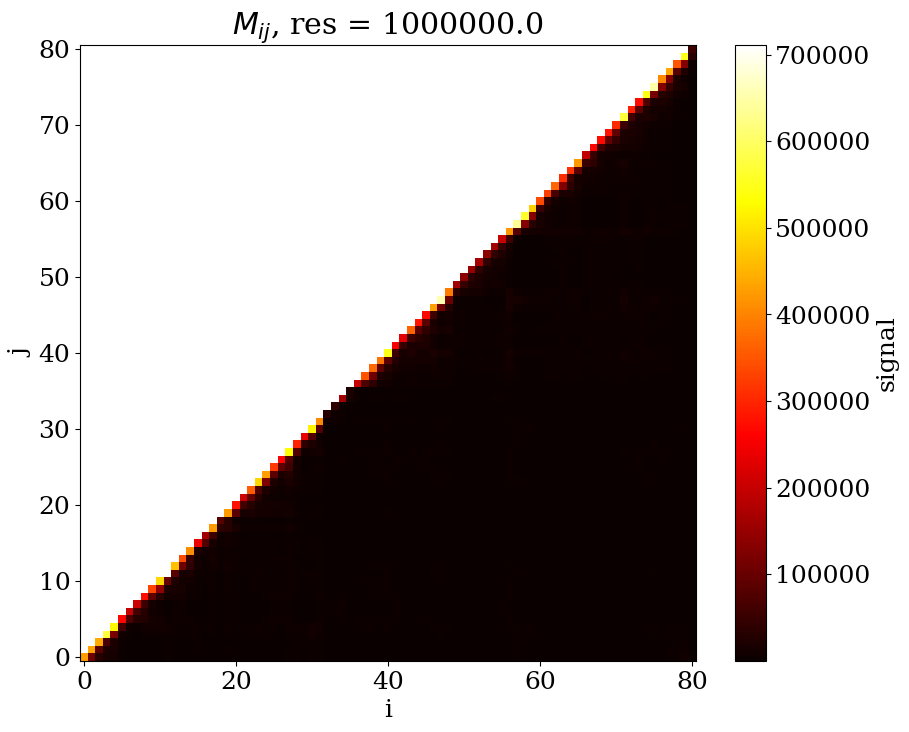

In [336]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# 1. Create a pivot table to reshape the data into a grid for the heatmap
heatmap_data = Hi_c_raw_obs.pivot(columns='j', index='i', values=r'$M_{ij}$')

# 2. Plot the heatmap using imshow
plt.imshow(heatmap_data, cmap='hot', interpolation='nearest', origin='lower')

# Add color bar to indicate intensity values
plt.colorbar(label='signal')

# 3. Add labels and title
plt.xlabel('i')
plt.ylabel('j')
plt.title(r'$M_{ij}$, res = %s' % resolution)

# Show the plot
plt.show()

<Figure size 640x480 with 0 Axes>

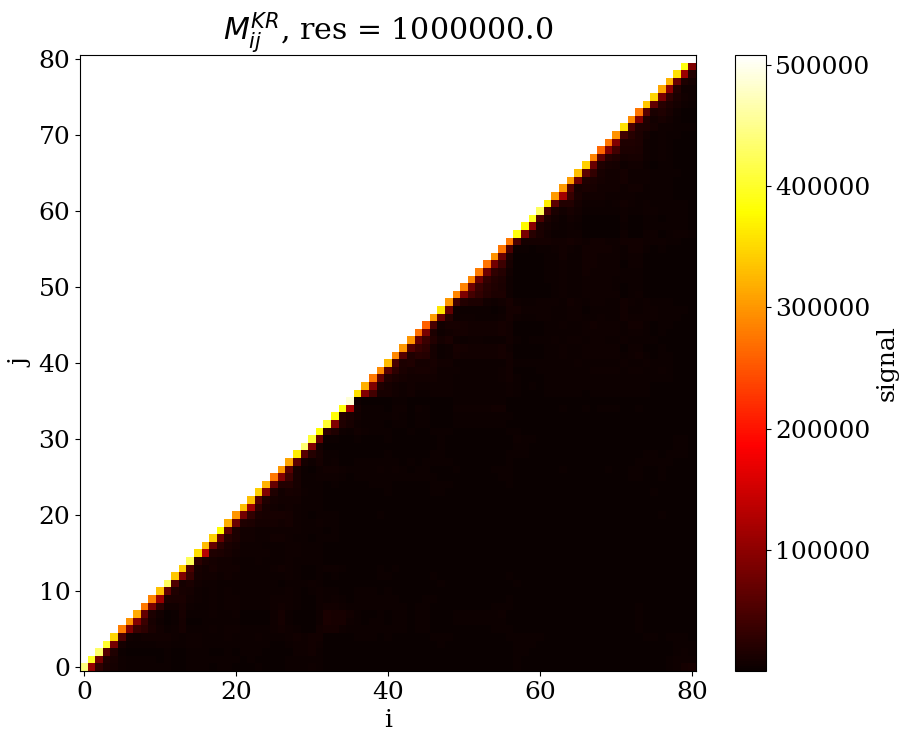

In [334]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# 1. Create a pivot table to reshape the data into a grid for the heatmap
heatmap_data = Hi_c_raw_obs.pivot(columns='j', index='i', values=r'$M_{ij}^{KR}$')

# 2. Plot the heatmap using imshow
plt.imshow(heatmap_data, cmap='hot', interpolation='nearest', origin='lower')

# Add color bar to indicate intensity values
plt.colorbar(label='signal')

# 3. Add labels and title
plt.xlabel('i')
plt.ylabel('j')
plt.title(r'$M_{ij}^{KR}$, res = %s' % resolution)

# Show the plot
plt.show()

<Figure size 640x480 with 0 Axes>

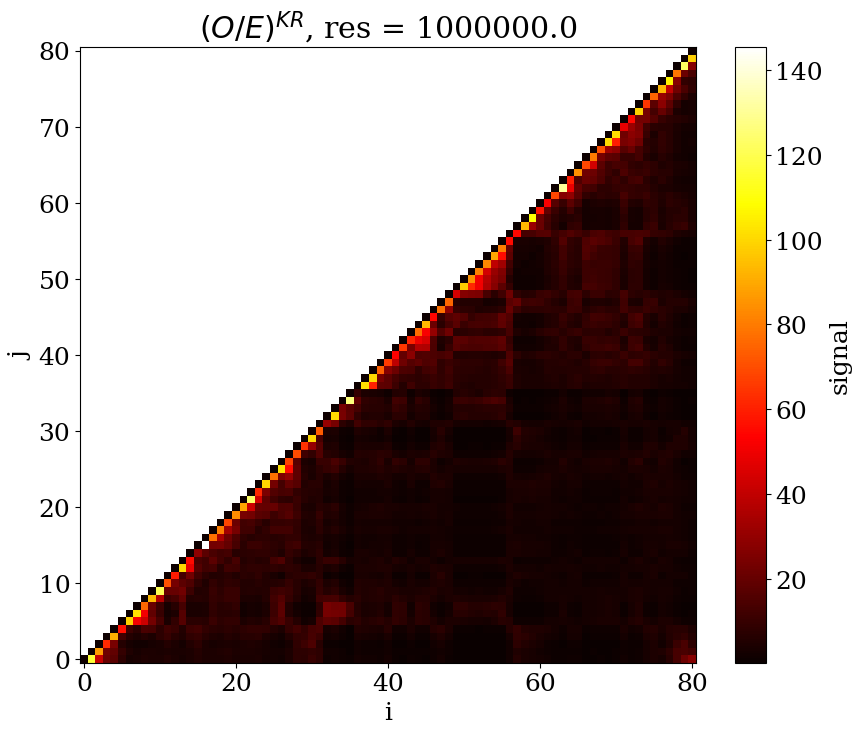

In [330]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# 1. Create a pivot table to reshape the data into a grid for the heatmap
heatmap_data = Hi_c_raw_obs.pivot(columns='j', index='i', values=r"$(O/E)^{KR}$")

# 2. Plot the heatmap using imshow
plt.imshow(heatmap_data, cmap="hot", interpolation='nearest', origin='lower')

# Add color bar to indicate intensity values
plt.colorbar(label='signal')

# 3. Add labels and title
plt.xlabel('i')
plt.ylabel('j')
plt.title(r"$(O/E)^{KR}$, res = %s" % resolution)

# Show the plot
plt.show()

# 4) Neural Net TODO

# OLD ANALYSIS:

In [60]:
# chr16_h3k9me3_data["truePeak"] = chr16_h3k9me3_data.start + chr16_h3k9me3_data.peak

C:\Users\tmhab\AppData\Local\Temp\ipykernel_59780\3188263119.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr16_h3k9me3_data["truePeak"] = chr16_h3k9me3_data.start + chr16_h3k9me3_data.peak


In [66]:
chr16_h3k9me3_data

,chromosome,start,end,name,score,strand,signalValue,pValue,qValue,peak,truePeak
25155,chr16,656350,657479,25357,20752,.,7.80,1.145499,1.849896,819,657169
16612,chr16,868391,869323,16735,13542,.,10.98,1.920481,2.748215,385,868776
10010,chr16,888869,892430,10085,22621,.,7.80,0.998783,1.696672,1043,889912
11661,chr16,933213,936229,11747,16925,.,5.23,1.474529,2.245336,1847,935060
18119,chr16,964197,965558,18248,14769,.,10.80,1.771422,2.543868,455,964652
...,...,...,...,...,...,...,...,...,...,...,...
16346,chr16,89972483,89974030,16468,11310,.,8.32,2.343439,3.201511,1267,89973750
22944,chr16,89974144,89975316,23124,16714,.,7.97,1.504982,2.272023,378,89974522
19268,chr16,90057181,90059622,19412,54489,.,6.60,0.196881,0.647289,2202,90059383
989,chr16,90059712,90063610,993,318,.,11.79,7.582638,7.793694,1204,90060916


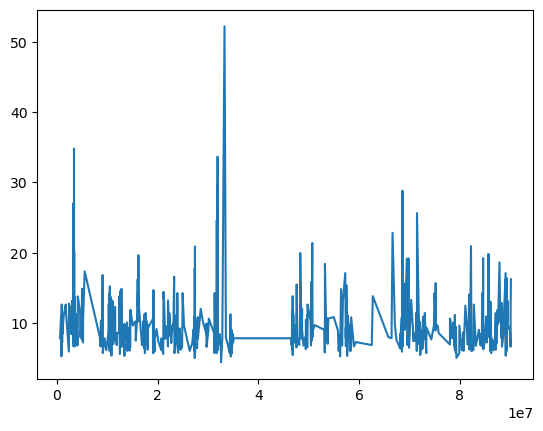

In [70]:
plt.plot(chr16_h3k9me3_data.truePeak.values, chr16_h3k9me3_data.signalValue)

In [112]:
chr16_h3k9me3_data["nuc"] = chr16_h3k9me3_data.truePeak.values // 200
chr16_h3k9me3_data

C:\Users\tmhab\AppData\Local\Temp\ipykernel_59780\201173917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr16_h3k9me3_data["nuc"] = chr16_h3k9me3_data.truePeak.values // 200


,chromosome,start,end,name,score,strand,signalValue,pValue,qValue,peak,truePeak,nuc
25155,chr16,656350,657479,25357,20752,.,7.80,1.145499,1.849896,819,657169,3285
16612,chr16,868391,869323,16735,13542,.,10.98,1.920481,2.748215,385,868776,4343
10010,chr16,888869,892430,10085,22621,.,7.80,0.998783,1.696672,1043,889912,4449
11661,chr16,933213,936229,11747,16925,.,5.23,1.474529,2.245336,1847,935060,4675
18119,chr16,964197,965558,18248,14769,.,10.80,1.771422,2.543868,455,964652,4823
...,...,...,...,...,...,...,...,...,...,...,...,...
16346,chr16,89972483,89974030,16468,11310,.,8.32,2.343439,3.201511,1267,89973750,449868
22944,chr16,89974144,89975316,23124,16714,.,7.97,1.504982,2.272023,378,89974522,449872
19268,chr16,90057181,90059622,19412,54489,.,6.60,0.196881,0.647289,2202,90059383,450296
989,chr16,90059712,90063610,993,318,.,11.79,7.582638,7.793694,1204,90060916,450304


In [152]:
chr16_h3k9me3_data["nuc_start"] = chr16_h3k9me3_data.start.values // 200
chr16_h3k9me3_data["nuc_end"] = chr16_h3k9me3_data.end.values // 200
chr16_h3k9me3_data

C:\Users\tmhab\AppData\Local\Temp\ipykernel_59780\3824968197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr16_h3k9me3_data["nuc_start"] = chr16_h3k9me3_data.start.values // 200
C:\Users\tmhab\AppData\Local\Temp\ipykernel_59780\3824968197.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr16_h3k9me3_data["nuc_end"] = chr16_h3k9me3_data.end.values // 200


,chromosome,start,end,name,score,strand,signalValue,pValue,qValue,peak,nuc_start,nuc_end
2979,chr16,2357706,2357835,Peak_18719,31,.,3.36350,3.15500,0.09098,50,11788,11789
3009,chr16,3077832,3077972,Peak_503,87,.,6.40491,8.73385,3.47371,89,15389,15389
3046,chr16,3223578,3223688,Peak_4718,58,.,4.77506,5.80953,1.61630,54,16117,16118
3047,chr16,3223793,3224036,Peak_789,81,.,6.05377,8.11092,3.07401,80,16118,16120
3048,chr16,3224096,3225075,Peak_911,79,.,5.62315,7.99793,3.01658,583,16120,16125
...,...,...,...,...,...,...,...,...,...,...,...,...
3183,chr16,89129792,89129902,Peak_8870,49,.,4.47311,4.98348,0.99766,33,445648,445649
3184,chr16,89226618,89226752,Peak_2479,63,.,5.12545,6.35717,1.86798,40,446133,446133
3185,chr16,89249988,89250098,Peak_6899,50,.,4.49746,5.02485,0.99766,93,446249,446250
3186,chr16,89376904,89377093,Peak_19404,27,.,3.13807,2.73789,0.00000,40,446884,446885


In [154]:
np.sum(chr16_h3k9me3_data.nuc_end.values - chr16_h3k9me3_data.nuc_start.values)

262

## max of 8649 nucleosomes with marks. WAY To LOW

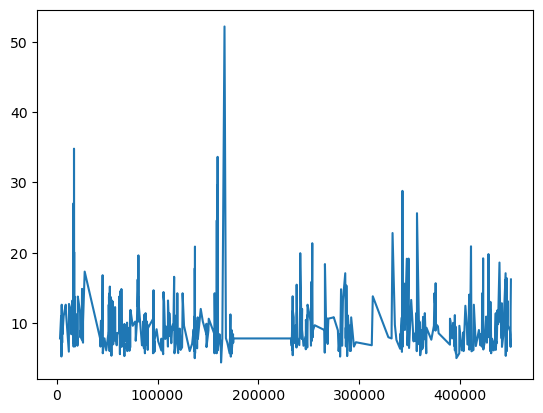

In [116]:
plt.plot(chr16_h3k9me3_data.nuc.values, chr16_h3k9me3_data.signalValue.values)

In [124]:
np.sum(chr16_h3k9me3_data.signalValue.values<50)

668

In [142]:
# chr16_h3k9me3_data.signalValue.values

In [118]:
chr16_h3k9me3_arr = np.zeros(450606)


array([0., 0., 0., ..., 0., 0., 0.])